<a href="https://colab.research.google.com/github/akshatshah91/Game-AI/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [141]:
# hyper parameters
EPISODES = 200  # number of episodes
EPS_START = 1  # e-greedy threshold start value
EPS_END = 0.001  # e-greedy threshold end value
EPS_DECAY = 0.995  # e-greedy threshold decay
GAMMA = 0.8  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
HIDDEN_LAYER = 256  # NN hidden layer size

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [140]:
class DQN(nn.Module):
    def __init__(self, inputSize, outputSize):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(inputSize, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, outputSize)
        self.memory = []
        self.batchSize = 64
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.epsilon = EPS_START

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

    def store(self, transition):
      self.memory.append(transition)

    def act(self, state):
      if random.random() < self.epsilon:
        return LongTensor([[random.randrange(self.outputSize)]])
      else:
        return self(Variable(state).type(FloatTensor)).data.max(1)[1].view(1,1)

    def update(self):
      if len(self.memory) < self.batchSize:
        return
      transitions = random.sample(self.memory, self.batchSize)
      state,action,reward,nextState = zip(*transitions)
      state = Variable(torch.cat(state))
      action = Variable(torch.cat(action))
      reward = Variable(torch.cat(reward))
      nextState = Variable(torch.cat(nextState))
      qValues = self(state).gather(1,action)
      maxQValues = self(nextState).detach().max(1)[0]
      expectedQValues = reward + (GAMMA * maxQValues)
      loss = F.smooth_l1_loss(qValues, expectedQValues)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if self.epsilon > EPS_END:
        self.epsilon *= EPS_DECAY

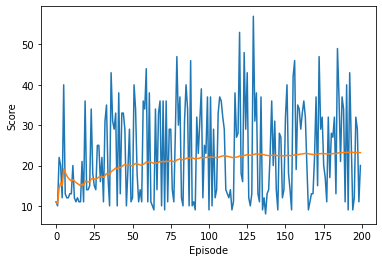

In [142]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQN(state_size, action_size)
optimizer = optim.Adam(agent.parameters(),LR)
rewards = []
avg = []
for x in range(1, EPISODES+1):
  state = env.reset()
  gameOver = False
  total = 0
  while not gameOver:
    action = agent.act(FloatTensor([state]))
    nextState,reward,gameOver,_ = env.step(action.detach().numpy()[0][0])
    agent.store((FloatTensor([state]), action, FloatTensor([reward]), FloatTensor([nextState])))
    state = nextState
    total += reward
    agent.update()
  rewards.append(total)
  avg.append(sum(rewards)/len(rewards))
  plt.xlabel("Episode")
  plt.ylabel("Score")
  plt.plot(rewards, label="reward")
  plt.plot(avg, label="average")
  plt.show()
  clear_output(wait=True)